# Part A: Stock Price Forecasting

---

# Background Information

### Time series analysis is a powerful tool for forecasting stock prices due to its ability to capture temporal dependencies, trends, and seasonality in market data. By analyzing historical price patterns, time series models can provide accurate predictions of future price movements, aided by high-frequency data and specialized forecasting techniques. These models offer valuable insights for investors and analysts, enabling informed decision-making and optimization of investment strategies.

---

### Importing Libraries

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Remove future warning

In [223]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

---

## Handling Missing Values

### First, I will clean the data by addressing missing values

In [224]:
# Load in my dataset
df_stocks = pd.read_csv('Data Files/CA2-Stock-Price-Data.csv')
df_stocks.head()

,Date,Apple,Amazon,DBS
0,10/1/2018,56.814999,100.218002,25.969999
1,10/2/2018,57.320000,98.565498,25.629999
2,10/3/2018,58.017502,97.638000,25.950001
3,10/4/2018,56.997501,95.471001,25.760000
4,10/5/2018,56.072498,94.482498,25.770000


In [225]:
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1257 non-null   object 
 1   Apple   1257 non-null   float64
 2   Amazon  1257 non-null   float64
 3   DBS     1257 non-null   float64
dtypes: float64(3), object(1)
memory usage: 39.4+ KB


### The Date column is currently stored as an object type, so we'll need to convert it to a date data type later the remaining values we'll be predicting are all continuous float values, and therefore, we won't need to modify their formats

In [226]:
df_stocks.describe()

,Apple,Amazon,DBS
count,1257.000000,1257.000000,1257.000000
mean,116.168385,124.791237,28.185863
std,46.945568,32.495925,4.738732
min,35.547501,67.197998,16.879999
25%,66.592499,93.489998,24.879999
50%,129.610001,120.970001,28.650000
75%,152.589996,158.100494,32.480000
max,196.449997,186.570496,37.250000


### As mentioned earlier, we will now proceed to convert the Date object into a date data type

In [227]:
df_stocks['Date'] = pd.to_datetime(df_stocks['Date'])

df_stocks = df_stocks.set_index(df_stocks['Date']).asfreq('d')

df_stocks = df_stocks.drop('Date', axis=1)


In [228]:
df_stocks.isna().sum()


Apple     567
Amazon    567
DBS       567
dtype: int64

### We identified missing values in the dataset. To address this, I'll use a backfill method, which fills missing values with the most recent known value. This approach is suitable for time series data as it preserves the temporal order of observations, crucial for maintaining the integrity of time-dependent patterns and trends

In [229]:
df_stocks.backfill(inplace=True)

In [230]:
df_stocks.isna().sum()

Apple     0
Amazon    0
DBS       0
dtype: int64

<Figure size 640x480 with 0 Axes>

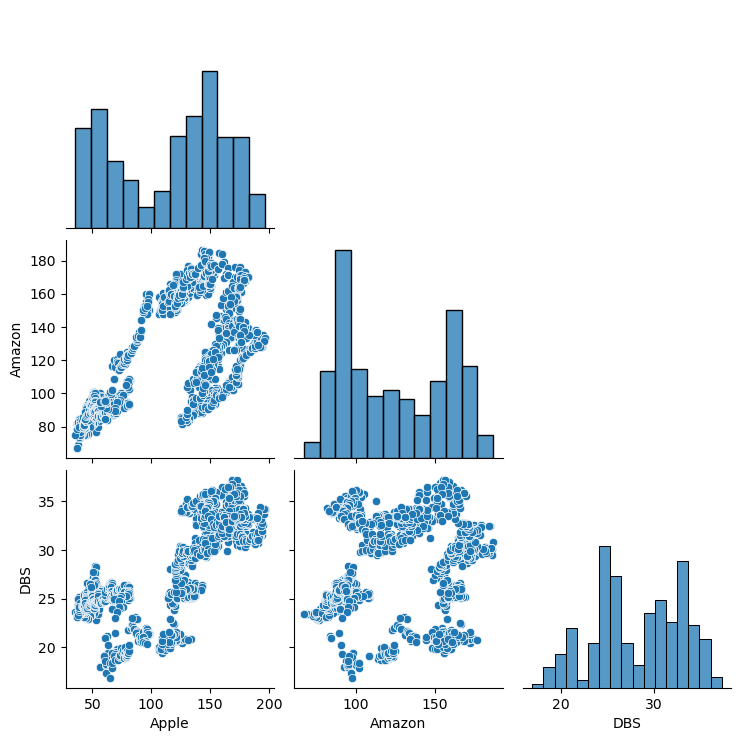

In [231]:
fig = plt.figure()
sns.pairplot(df_stocks, corner=True)
plt.show()

### We can observe that there isn't a strong relationship between each type of consumption. They all exhibit very weak positive or negative correlations

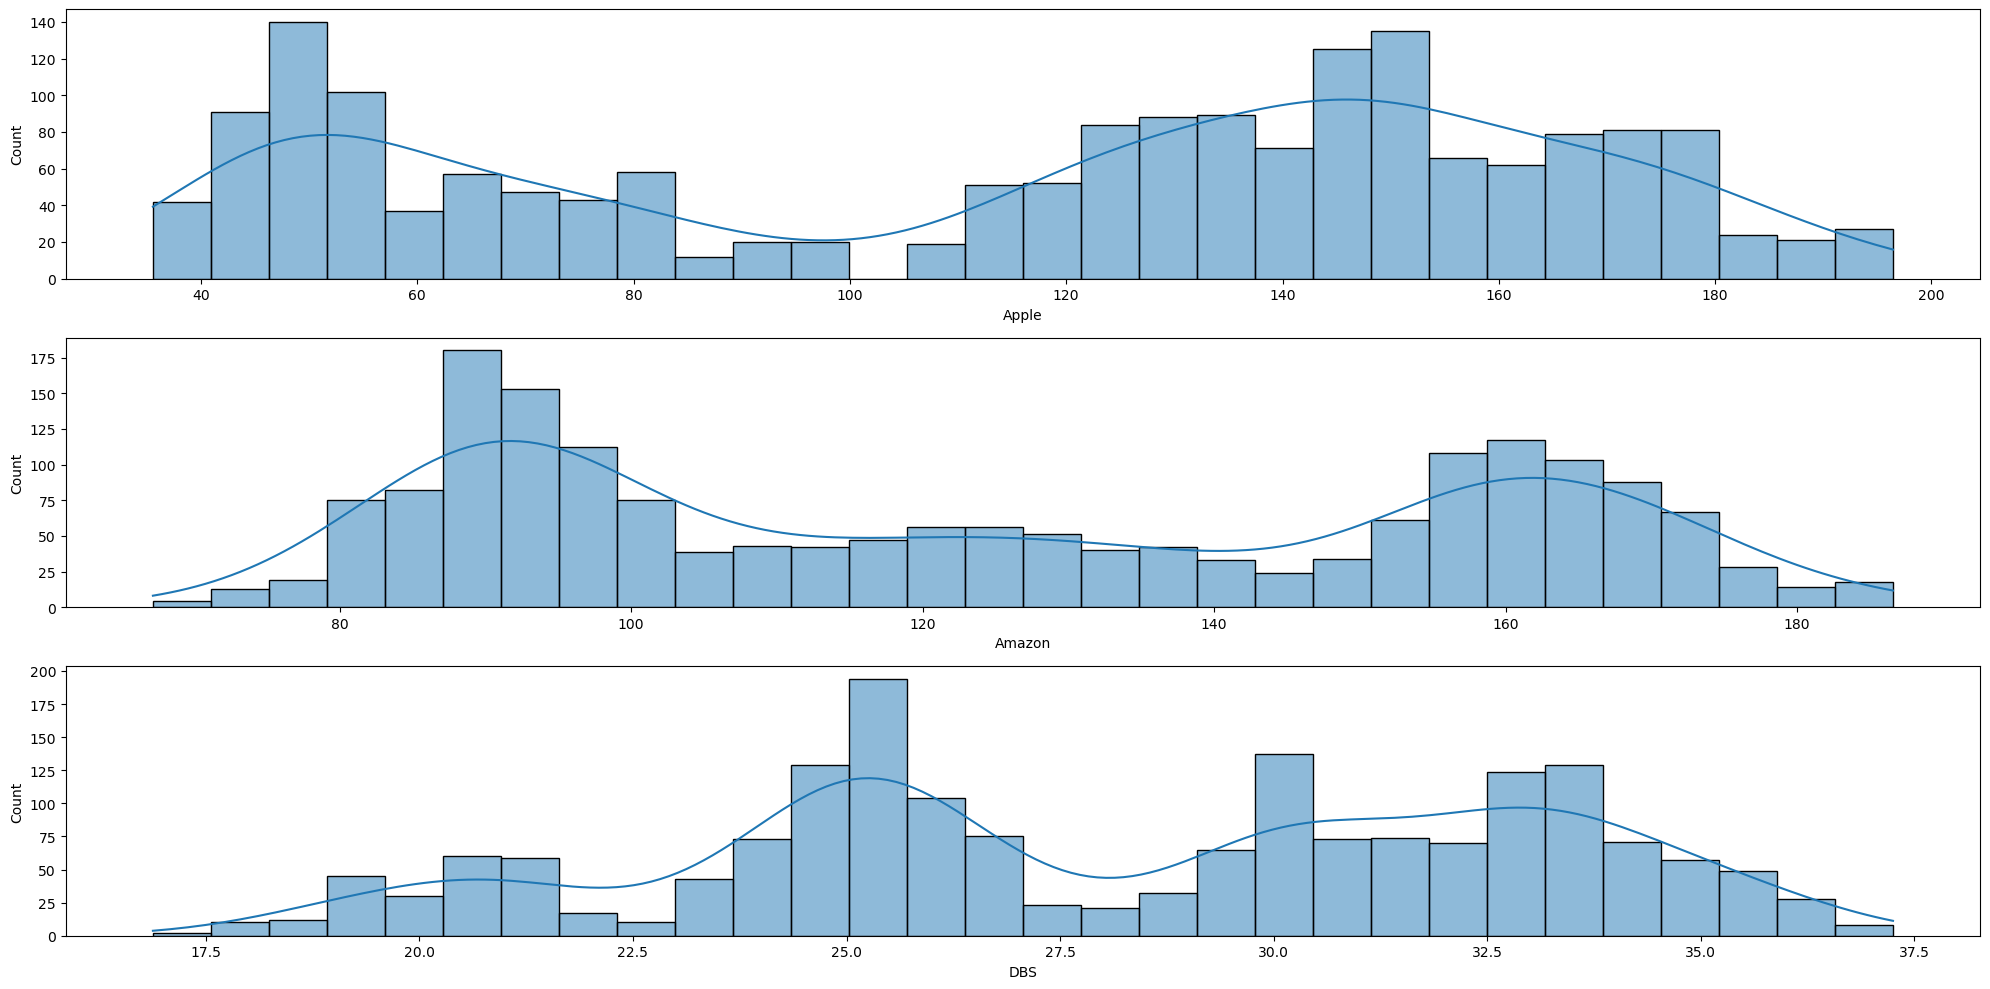

In [232]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10), tight_layout=True)

for i, y_temp in enumerate(["Apple", "Amazon", "DBS"]):
    sns.histplot(data=df_stocks, x=y_temp, bins=30, ax=ax[i], kde=True)

### We can observe that the stock prices for Apple are right-skewed, for Amazon they follow a normal distribution, and for DBS they are also skewed to the right

## Time Series Visualisation

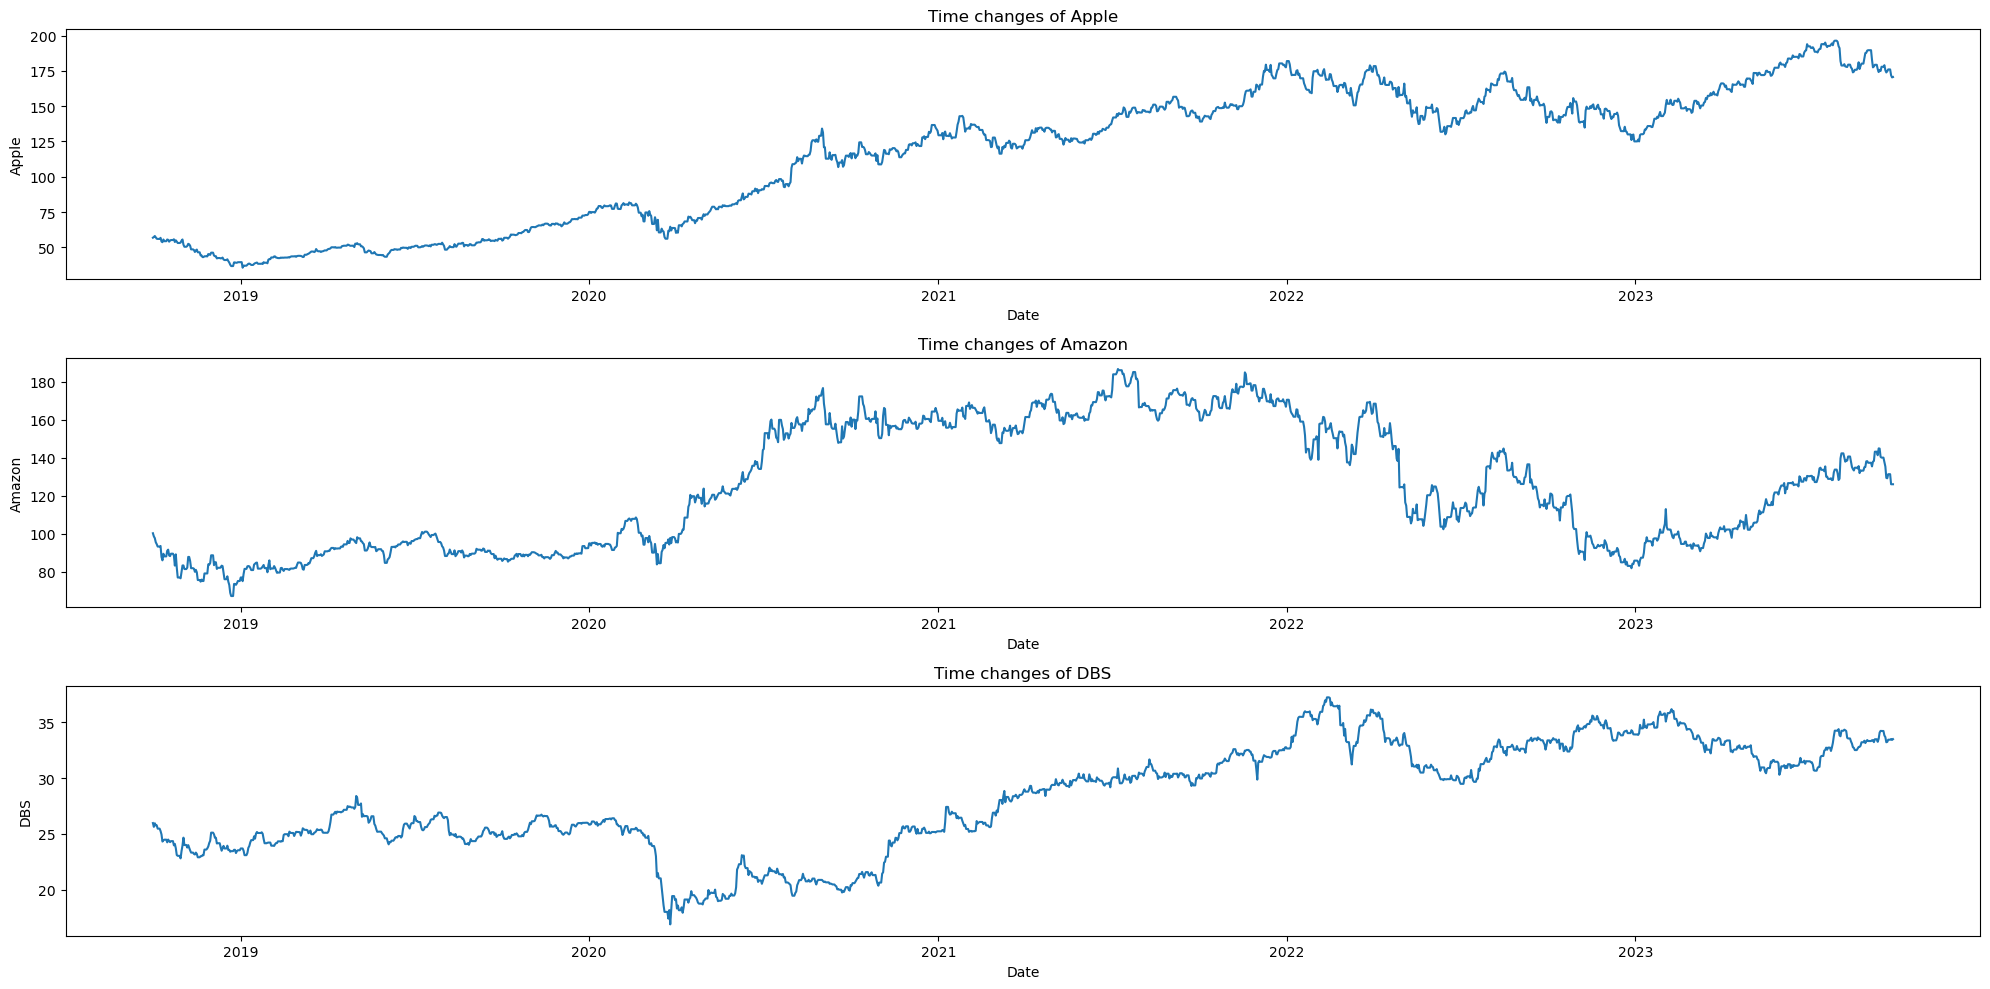

In [233]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10), tight_layout=True)
for i, y_temp in enumerate(["Apple", "Amazon", "DBS"]):
    sns.lineplot(df_stocks[y_temp], ax=ax[i])
    ax[i].set_title("Time changes of " + y_temp)
    
plt.show()

### For Apple, there is a noticeable positive upward trend in stock prices, while for Amazon and DBS, there isn't a clear trend

## Seasonal Decomposition

Column: Apple
Seasonal Decomposition: 7


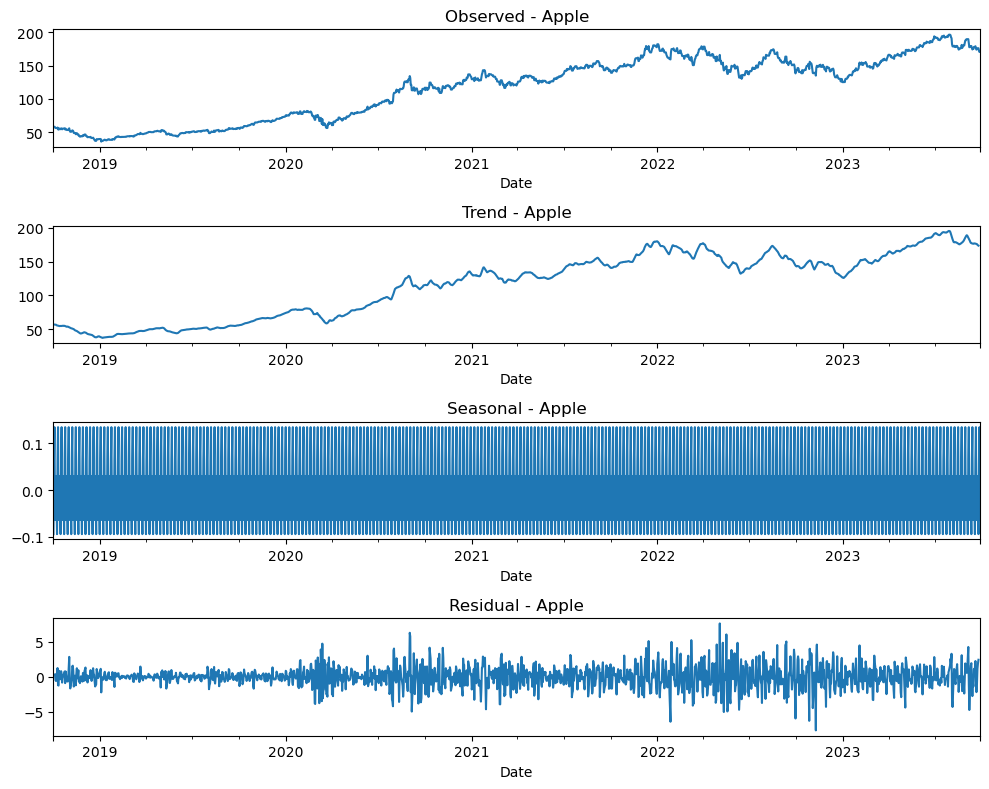

Column: Amazon
Seasonal Decomposition: 7


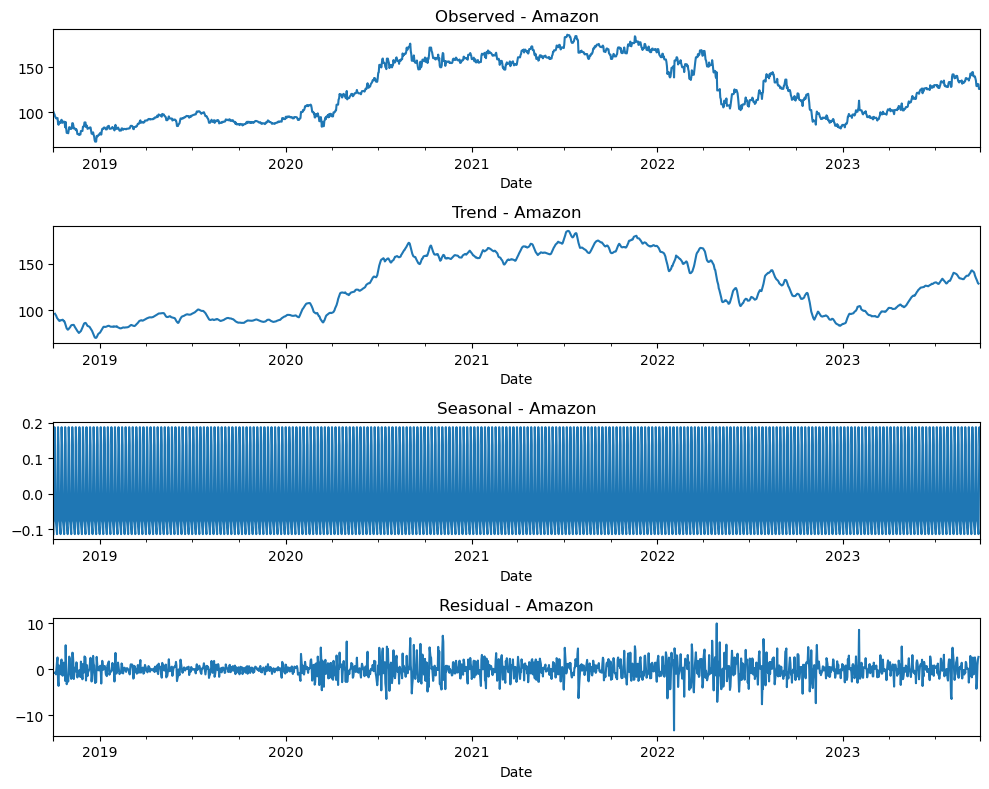

Column: DBS
Seasonal Decomposition: 7


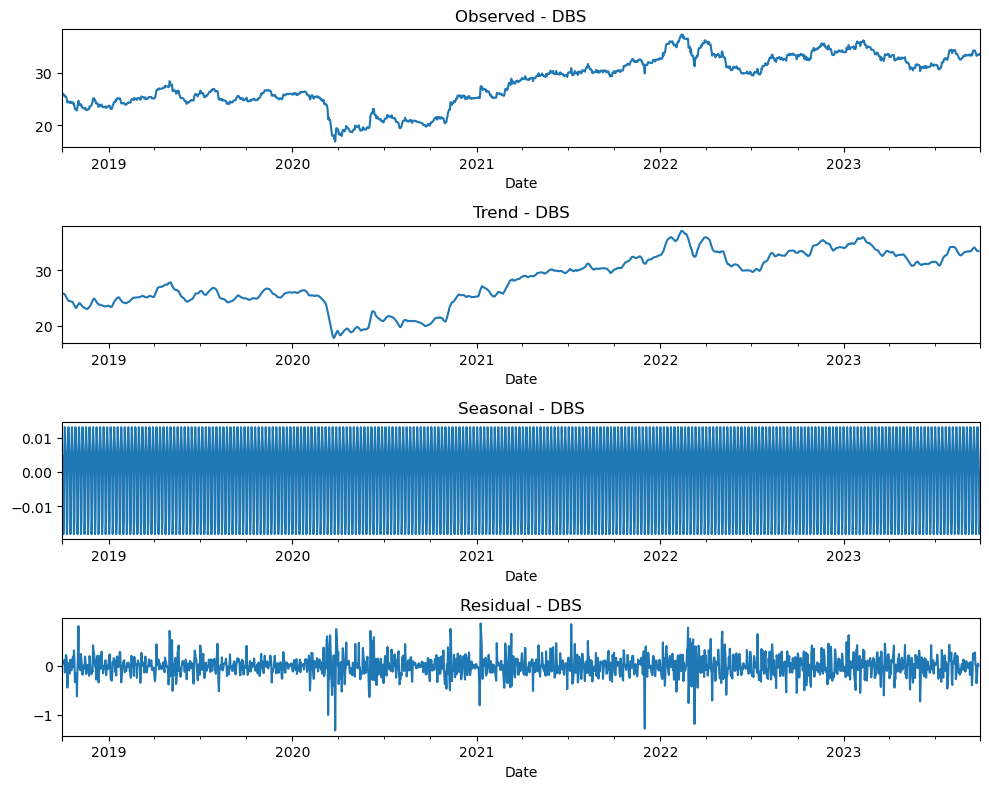

In [234]:
for column in df_stocks.columns:
    # perform seasonal decomposition
    decomposition = seasonal_decompose(df_stocks[column], model='additive')
    
    # print out the seasonality info
    print(f"Column: {column}")
    print(f"Seasonal Decomposition: {len(decomposition.seasonal.drop_duplicates())}")
    
    # plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(10, 8))
    decomposition.observed.plot(ax=axes[0], title=f'Observed - {column}')
    decomposition.trend.plot(ax=axes[1], title=f'Trend - {column}')
    decomposition.seasonal.plot(ax=axes[2], title=f'Seasonal - {column}')
    decomposition.resid.plot(ax=axes[3], title=f'Residual - {column}')
    plt.tight_layout()
    plt.show()


### All columns had a seasonal decomposition of 7 indicate that the time series data exhibits a weekly seasonal pattern, with variations repeating every 7 observations

## P-Value

### Next, I'll perform an Augmented Dickey-Fuller test on the data. This statistical method helps determine whether a time series is stationary or non-stationary by assessing the presence of a unit root. If the p-value obtained from the test is below 0.05, we reject the null hypothesis of non-stationarity, indicating that the time series is stationary. This is essential for ensuring the reliability of my forecasting model

In [235]:
for column in df_stocks.columns:
    result = adfuller(df_stocks[column])
    print(f'ADF Test Results for {column}:')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05: # if p-value lass than 0.05
        print('Reject Null Hypothesis - Time Series is Stationary')
    else:
        print('Fail to Reject Null Hypothesis - Time Series is Non-Stationary')
    print()


ADF Test Results for Apple:
p-value: 0.7725560183674318
Fail to Reject Null Hypothesis - Time Series is Non-Stationary

ADF Test Results for Amazon:
p-value: 0.46082937619768466
Fail to Reject Null Hypothesis - Time Series is Non-Stationary

ADF Test Results for DBS:
p-value: 0.5930355400987363
Fail to Reject Null Hypothesis - Time Series is Non-Stationary



### As observed for all columns, the p-value exceeded 0.05, indicating that we fail to reject the null hypothesis. This suggests that the time series is non-stationary

## Differencing

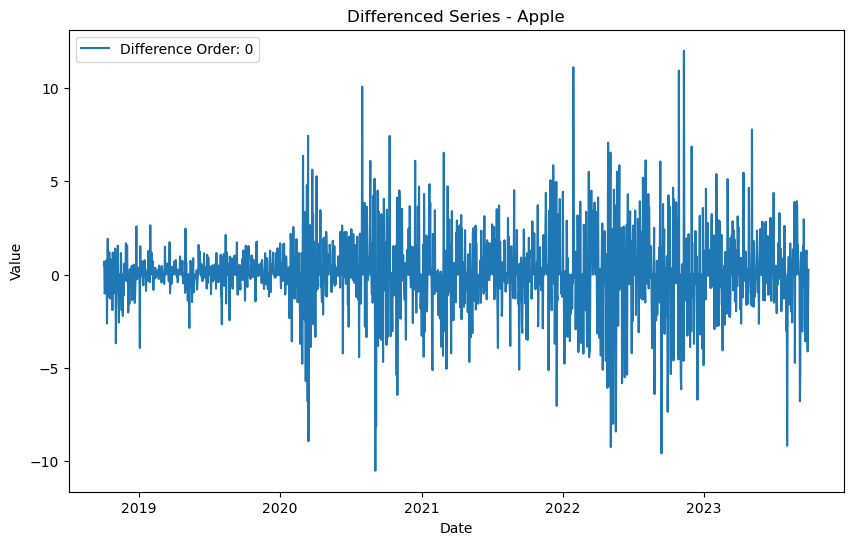

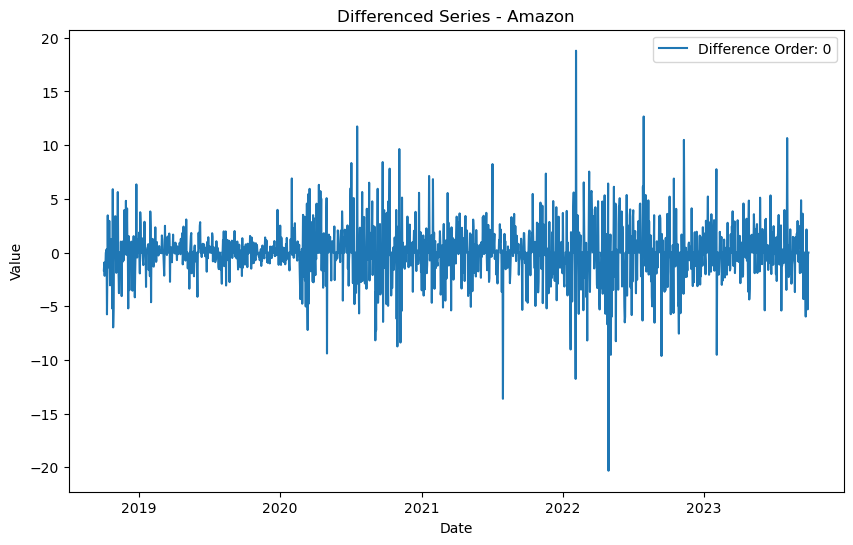

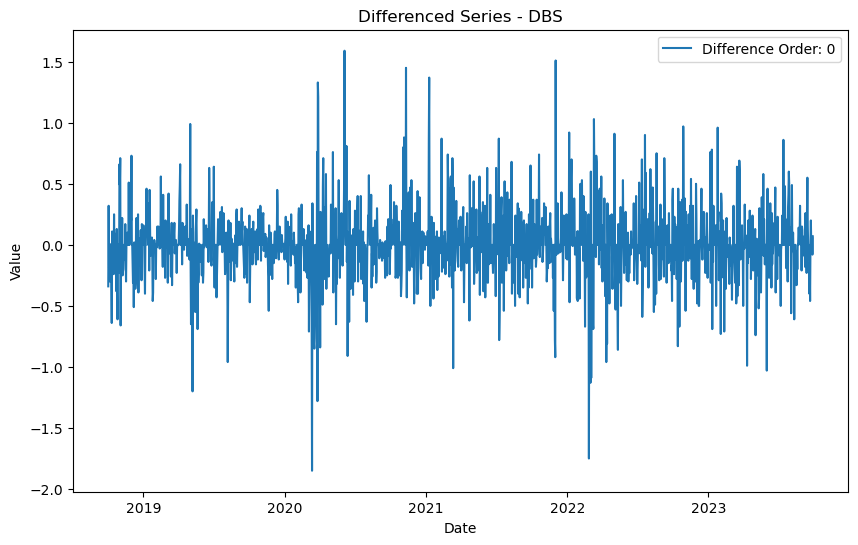

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def difference_until_stationary(series):
    # initialize differencing order
    order = 0
    
    # perform differencing and adf test until p-value is below 0.05
    while True:
        # Carry out differencing
        diff_series = series.diff().dropna()
        
        # perform adf test
        result = adfuller(diff_series)
        
        # check if p-value is below 0.05
        if result[1] < 0.05:
            return diff_series, order
        
        # update series and order for next iteration
        series = diff_series
        order += 1

# create a copy of the dataframe to store the differenced series
df_differenced = df_stocks.copy()

# iterate over each stock column
for column in df_stocks.columns:
    # get the column data
    series = df_stocks[column]
    
    # carry out differencing until stationary
    differenced_series, order = difference_until_stationary(series)
    
    # save the differenced series in the copy dataframe
    df_differenced[column] = differenced_series

    # Plot differenced series
    plt.figure(figsize=(10, 6))
    plt.plot(differenced_series, label=f'Difference Order: {order}')
    plt.title(f'Differenced Series - {column}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


## Partial Autocorrelation Function and Autocorrelation Function analysis

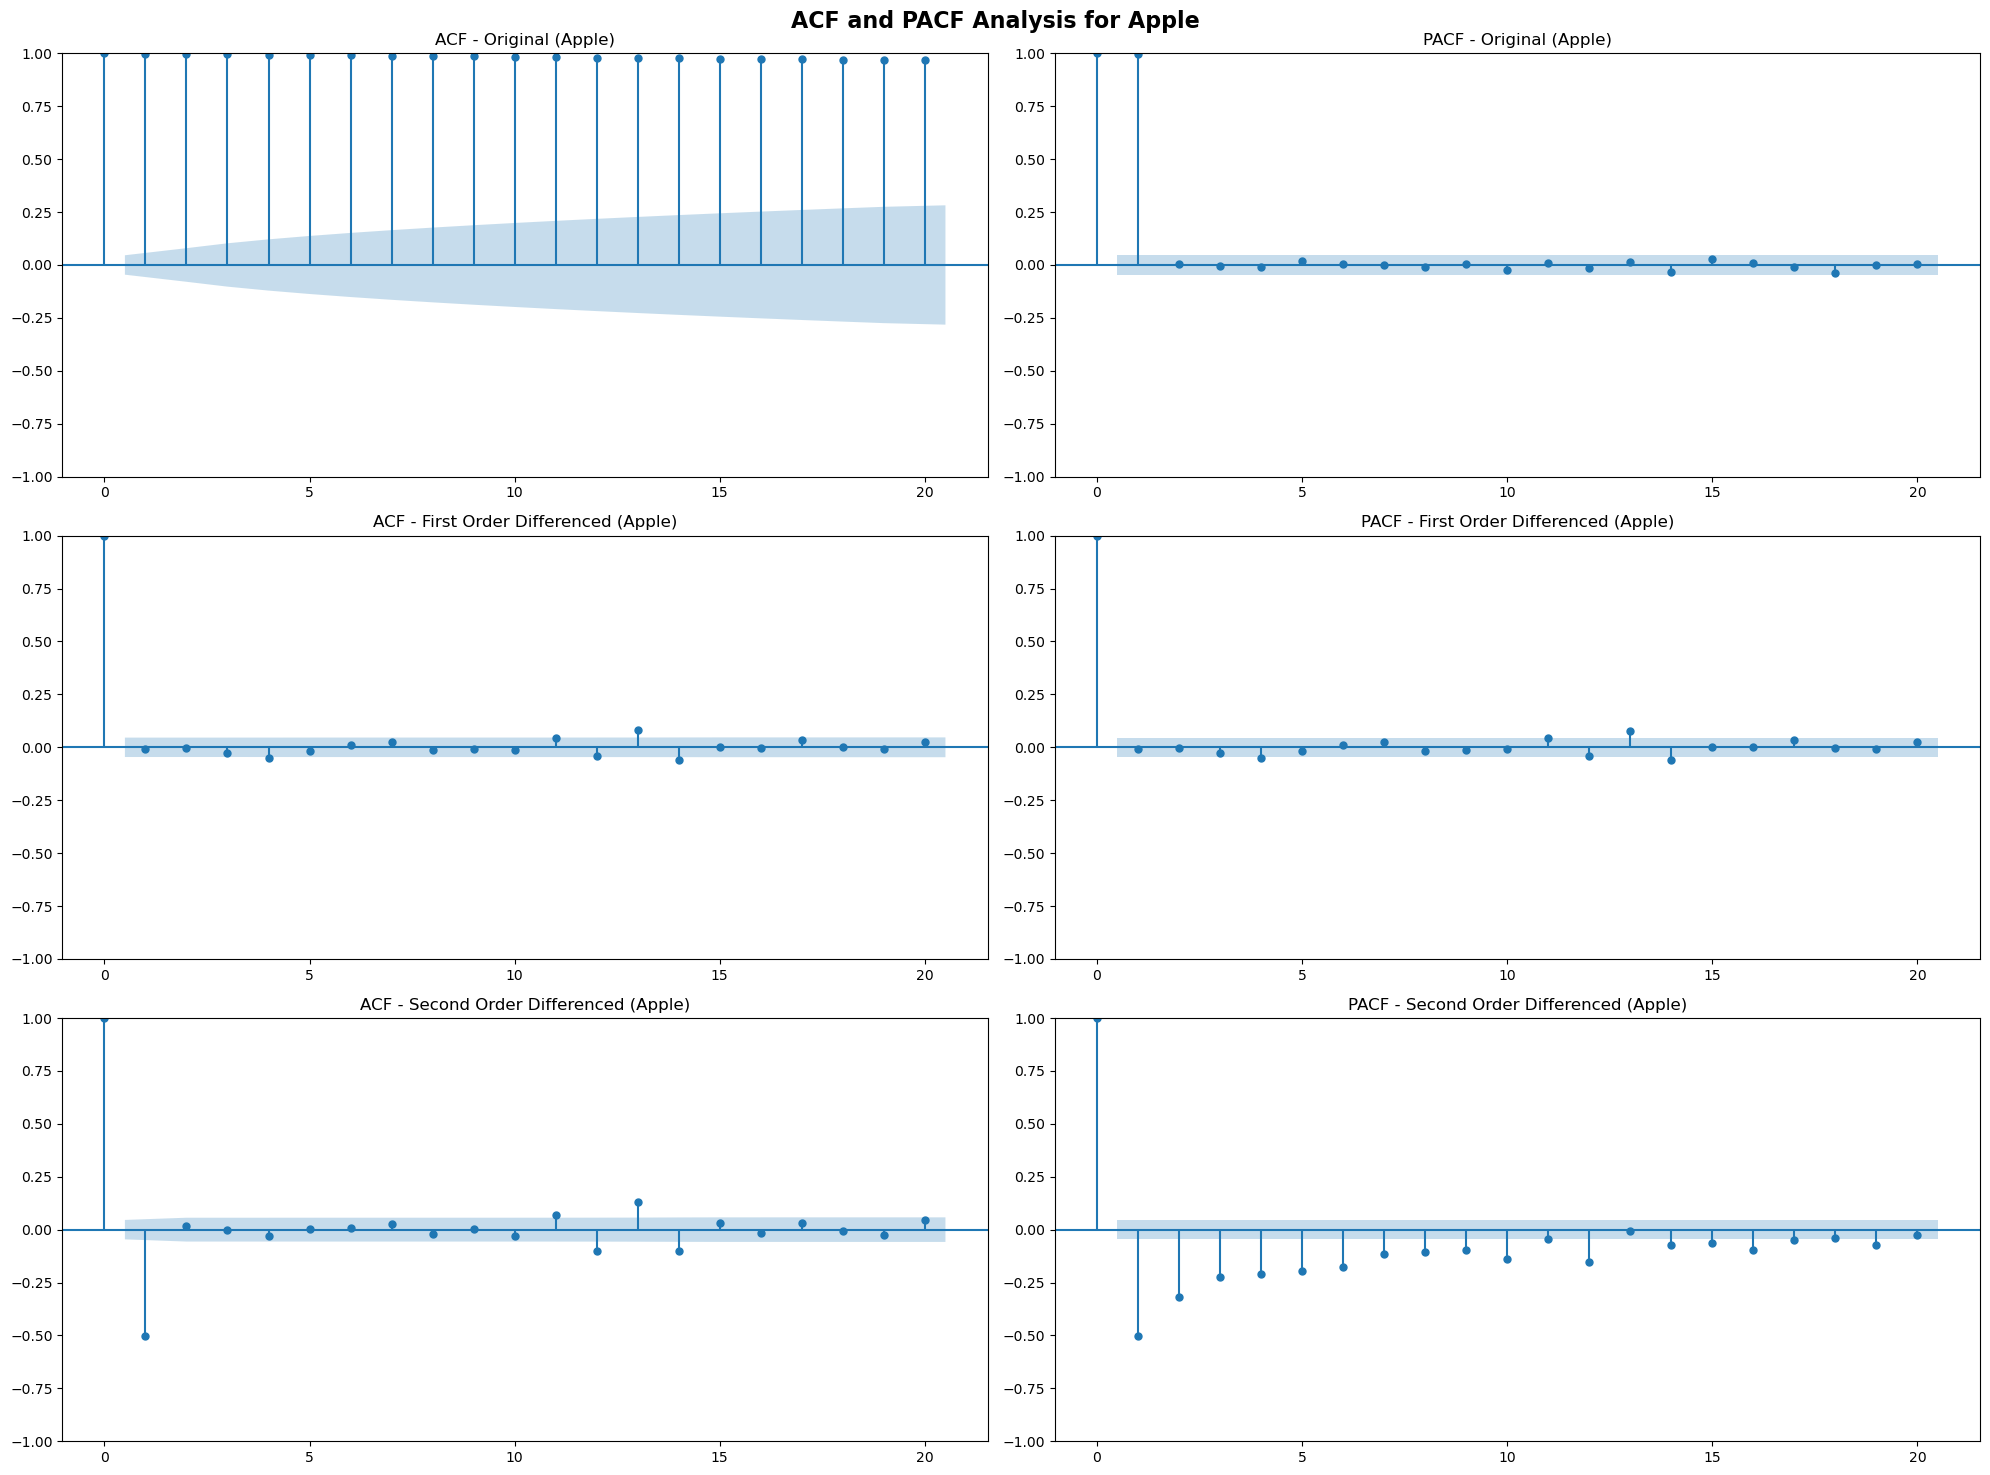

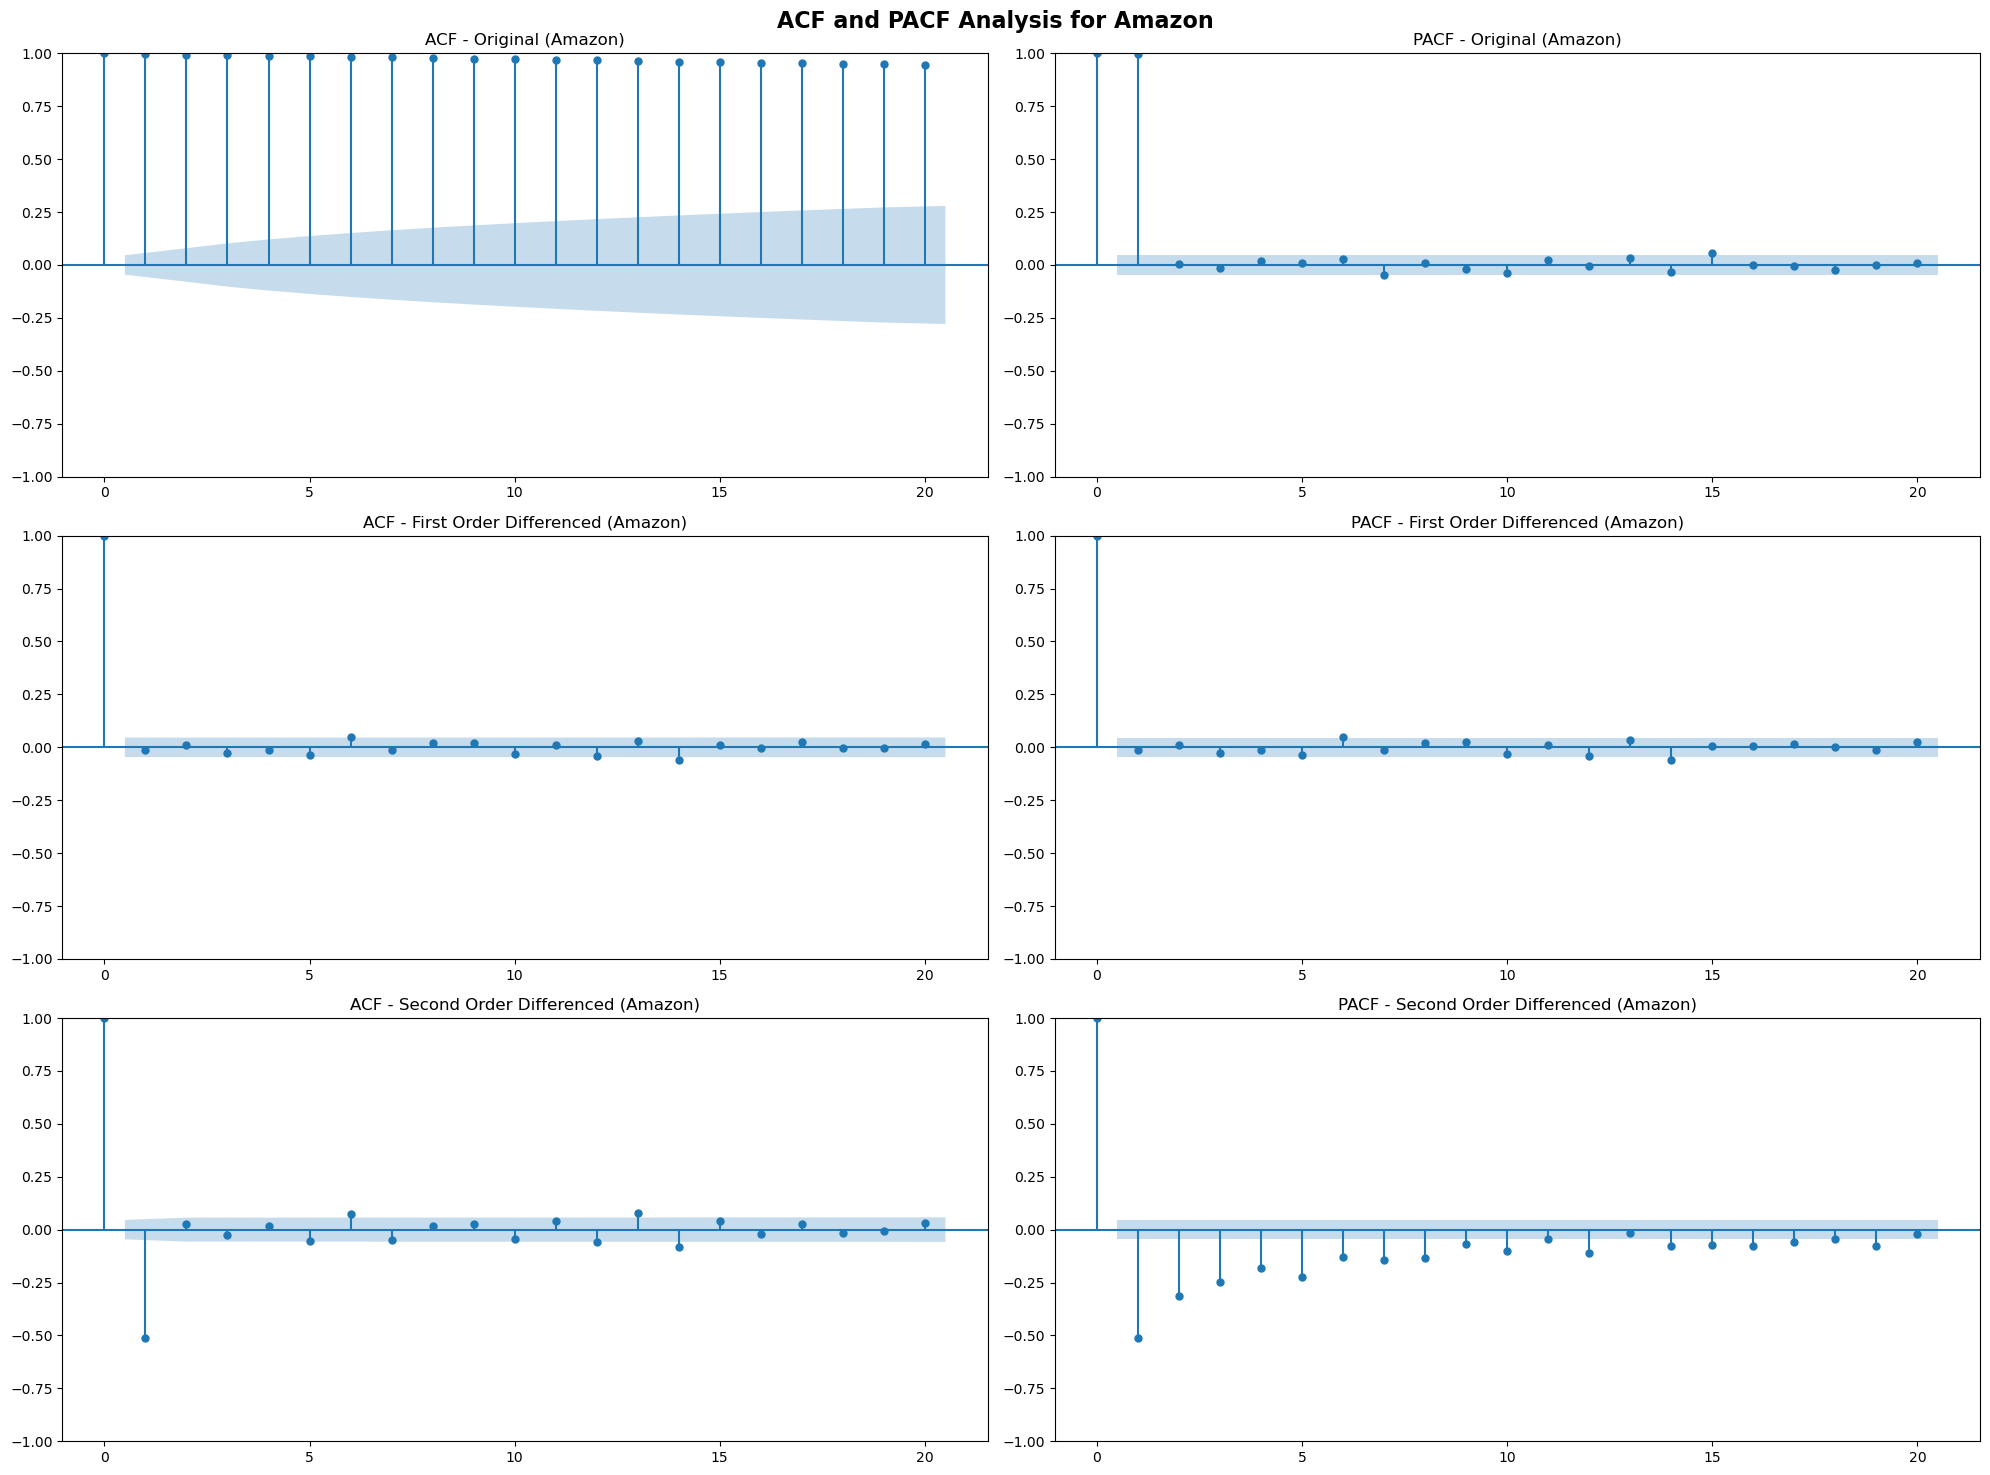

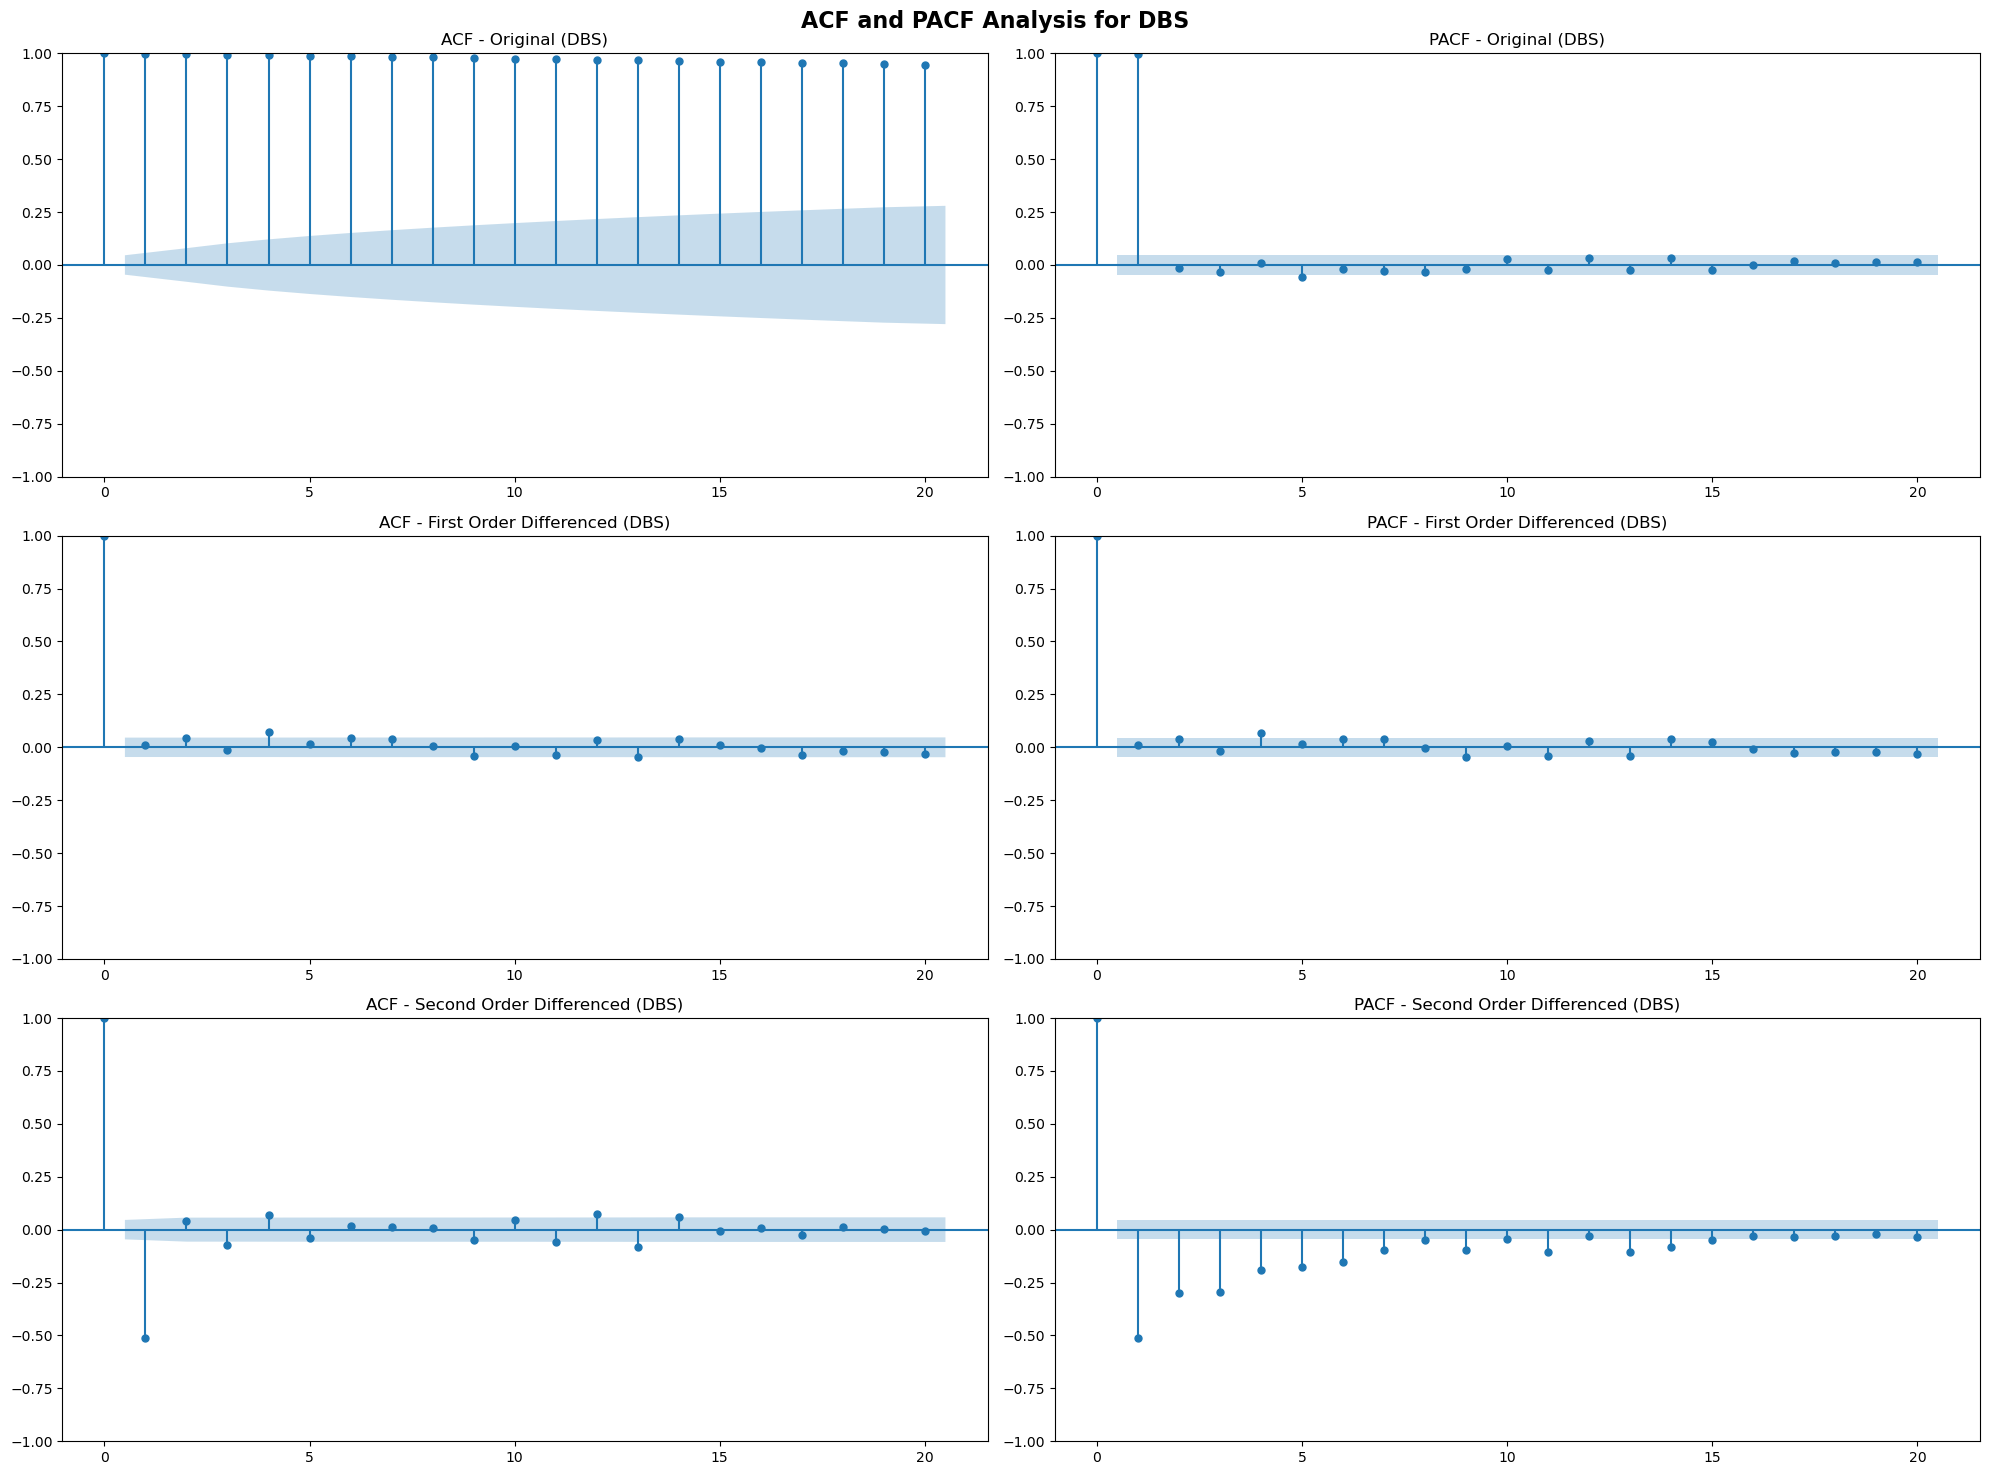

In [238]:
# iterate over each column in the DataFrame
for i, column in enumerate(df_stocks.columns):
    # my subplot
    fig, ax = plt.subplots(3, 2, figsize=(20, 15), tight_layout=True)
    
    # plot acf and pacf for the original series
    plot_acf(df_stocks[column], lags=20, ax=ax[0, 0])
    plot_pacf(df_stocks[column], lags=20, ax=ax[0, 1])
    ax[0, 0].set_title(f'ACF - Original ({column})')
    ax[0, 1].set_title(f'PACF - Original ({column})')

    # plot acf and pacf for the first-order differenced series
    plot_acf(df_stocks[column].diff().dropna(), lags=20, ax=ax[1, 0])
    plot_pacf(df_stocks[column].diff().dropna(), lags=20, ax=ax[1, 1])
    ax[1, 0].set_title(f'ACF - First Order Differenced ({column})')
    ax[1, 1].set_title(f'PACF - First Order Differenced ({column})')

    # plot acf and pacf for the second-order differenced series
    plot_acf(df_stocks[column].diff().diff().dropna(), lags=20, ax=ax[2, 0])
    plot_pacf(df_stocks[column].diff().diff().dropna(), lags=20, ax=ax[2, 1])
    ax[2, 0].set_title(f'ACF - Second Order Differenced ({column})')
    ax[2, 1].set_title(f'PACF - Second Order Differenced ({column})')

    # my plot title
    fig.suptitle(f'ACF and PACF Analysis for {column}', fontsize=16, fontweight='bold')
    
    plt.show()


**Apple:**
- ACF: Shows a very slight Geometric Decay. This indicates that the autocorrelation values decrease gradually as the lag increases, but the decay is minimal.
- PACF: Shows a significant lag at 1. This means that there is a strong direct relationship between the current observation and the observation one time period ago.

**Amazon:**
- ACF: Also shows a very slight Geometric Decay, similar to Apple.
- PACF: Like Apple, it shows a significant lag at 1, indicating a strong direct relationship between consecutive observations.

**DBS:**
- ACF: Similarly, shows a very slight Geometric Decay.
- PACF: Also shows a significant lag at 1, suggesting a strong direct relationship between the current observation and the observation one time period ago.

In summary, for all three stocks, the ACF plots exhibit a very slight Geometric Decay, indicating a gradual decrease in autocorrelation values as the lag increases, although the decay is minimal. Additionally, the PACF plots show significant lags at 1 for each stock, suggesting a strong direct relationship between consecutive observations. These observations provide insights into the temporal dependencies present in each stock's data, which can guide the selection of appropriate time series models for further analysis and forecasting.


## Spliting Data

### we will use 80% of the data for training and 20% for testing

In [239]:
# calculate index to split the data
split_index = int(len(df_stocks) * 0.8)  # 80% for training 20% for testing

# split the data
train_data = df_stocks.iloc[:split_index]
test_data = df_stocks.iloc[split_index:]

print("Training set size:", len(train_data))
print("Test set size:", len(test_data))

print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Training set size: 1459
Test set size: 365
Training data shape: (1459, 3)
Test data shape: (365, 3)


In [240]:
y_train_dic = {}
y_test_dic = {}

for y_temp in ["Apple", "Amazon", "DBS"]:
    y_train_dic[y_temp] = train_data[y_temp]
    y_test_dic[y_temp] = test_data[y_temp]


# Baseline Models

### We will compare the performance of Holt's Exponential Smoothing, ARIMA, and SARIMAX models to determine the most suitable model for predicting stocks. Evaluation will be based on metrics such as Mean Absolute Percentage Error, Akaike Information Criterion, and Bayesian Information Criterion

In [241]:
def model_cv(
    model, endog, order=(1, 1, 1), splits=3, seasonal_order=None, max_iter=1000
):
    valid_rmse = []
    valid_mape = []
    train_rmse = []
    train_mape = []
    model_aic = []
    model_bic = []
    time_series = TimeSeriesSplit(n_splits=splits)
    for train_index, test_index in time_series.split(endog):
        y_train, y_test = endog.iloc[train_index], endog.iloc[test_index]
        if seasonal_order is None:
            model_fit = model(endog=y_train, order=order).fit(
                maxiter=max_iter, disp=False
            )
        else:
            model_fit = model(
                endog=y_train, seasonal_order=seasonal_order, order=order
            ).fit(maxiter=max_iter, disp=False)
        y_pred = model_fit.predict(
            start=y_test.index[0], end=y_test.index[-1]
        )
        valid_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        valid_mape.append(mean_absolute_percentage_error(y_test, y_pred))
        train_pred = model_fit.predict(
            start=y_train.index[0], end=y_train.index[-1]
        )
        train_rmse.append(mean_squared_error(y_train, train_pred, squared=False))
        train_mape.append(mean_absolute_percentage_error(y_train, train_pred))
        model_aic.append(model_fit.aic)
        model_bic.append(model_fit.bic)
    return (
        pd.Series(
            {
                "train_rmse": np.mean(train_rmse),
                "train_rmse_std": np.std(train_rmse),
                "valid_rmse": np.mean(valid_rmse),
                "valid_rmse_std": np.std(valid_rmse),
                "train_mape": np.mean(train_mape),
                "valid_mape": np.mean(valid_mape),
                "AIC": np.mean(model_aic),
                "BIC": np.mean(model_bic),
            },
            name=order,
        ),
        pd.DataFrame(
            {
                "train_rmse": train_rmse,
                "train_rmse_std": train_rmse,
                "valid_rmse": valid_rmse,
                "valid_rmse_std": valid_rmse,
                "train_mape": train_mape,
                "valid_mape": valid_mape,
                "AIC": model_aic,
                "BIC": model_bic,
            }
        ),
    )

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Apple   No. Observations:                 1459
Model:                          ARIMA   Log Likelihood               -7620.156
Date:                Fri, 09 Feb 2024   AIC                          15244.313
Time:                        20:14:52   BIC                          15254.884
Sample:                    10-01-2018   HQIC                         15248.256
                         - 09-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.6948      1.176     89.033      0.000     102.390     107.000
sigma2      2014.0102    148.283     13.582      0.000    1723.382    2304.639
Ljung-Box (L1) (Q):            

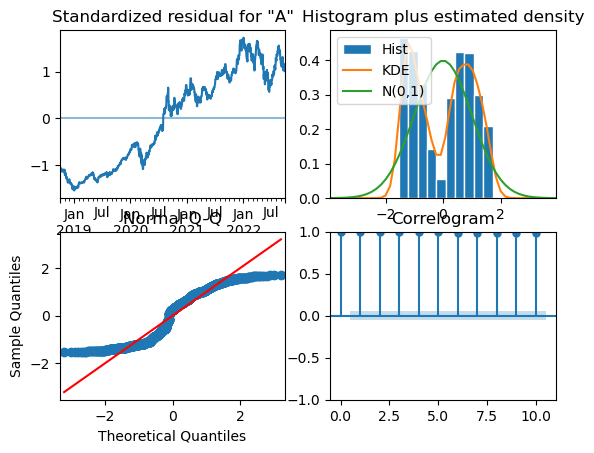

Exponential Smoothing (Holt-Winters) Model Summary:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Apple   No. Observations:                 1459
Model:             ExponentialSmoothing   SSE                           5239.138
Optimized:                         True   AIC                           1883.194
Trend:                             None   BIC                           1930.764
Seasonal:                      Additive   AICC                          1883.376
Seasonal Periods:                     7   Date:                 Fri, 09 Feb 2024
Box-Cox:                          False   Time:                         20:14:53
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9870136                

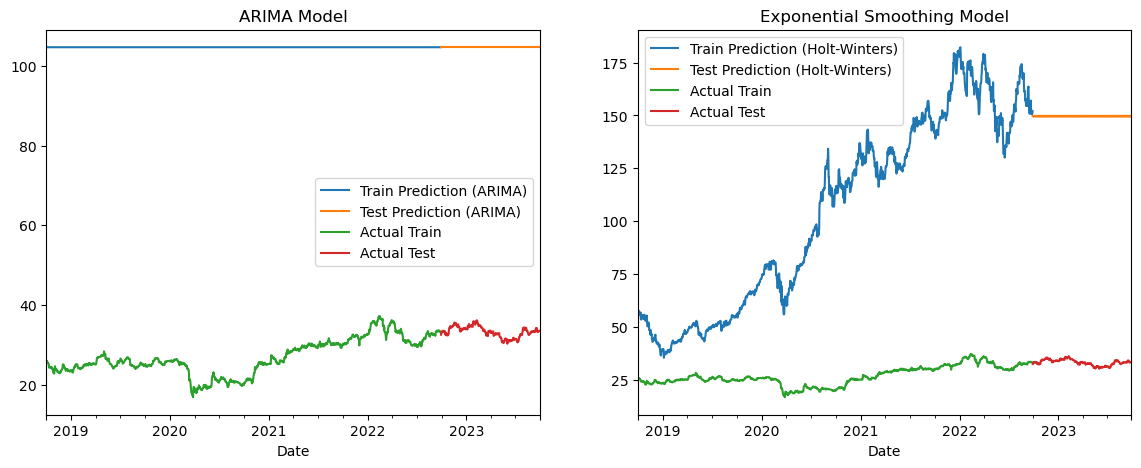

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                 Amazon   No. Observations:                 1459
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -3356.624
Date:                Fri, 09 Feb 2024   AIC                           6717.248
Time:                        20:14:55   BIC                           6727.819
Sample:                    10-01-2018   HQIC                          6721.191
                         - 09-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   4475.015      0.000       0.999       1.000
sigma2         5.7978      0.090     64.066      0.000       5.620       5.975
Ljung-Box (L1) (Q):            

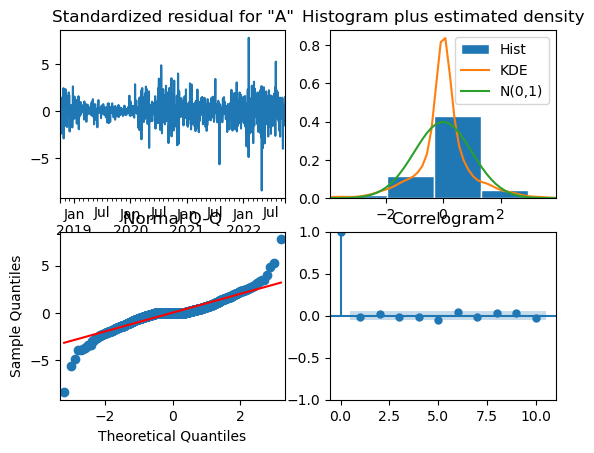

Exponential Smoothing (Holt-Winters) Model Summary:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Amazon   No. Observations:                 1459
Model:             ExponentialSmoothing   SSE                           8419.224
Optimized:                         True   AIC                           2575.286
Trend:                             None   BIC                           2622.856
Seasonal:                      Additive   AICC                          2575.469
Seasonal Periods:                     7   Date:                 Fri, 09 Feb 2024
Box-Cox:                          False   Time:                         20:14:56
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9858870                

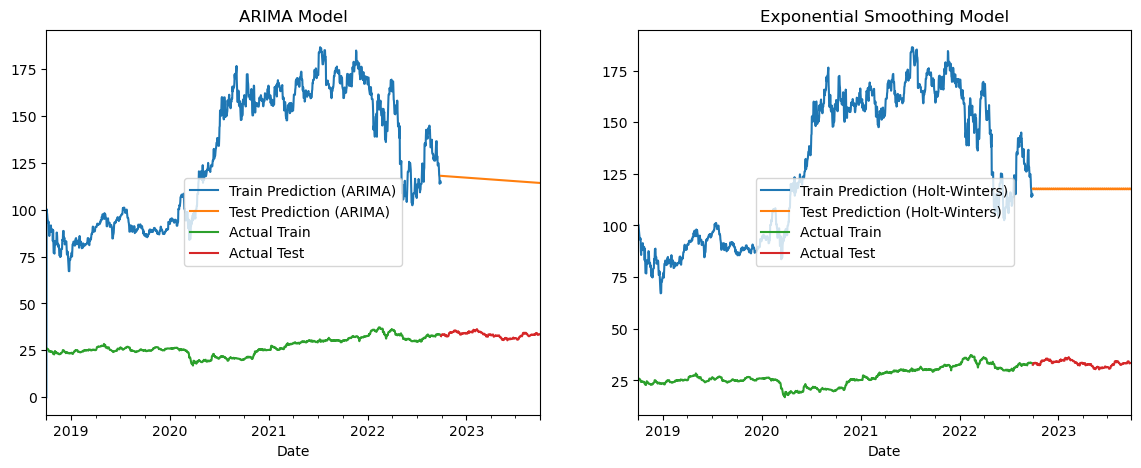

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                    DBS   No. Observations:                 1459
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -208.900
Date:                Fri, 09 Feb 2024   AIC                            421.801
Time:                        20:14:58   BIC                            432.372
Sample:                    10-01-2018   HQIC                           425.745
                         - 09-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   4564.407      0.000       1.000       1.000
sigma2         0.0775      0.001     56.352      0.000       0.075       0.080
Ljung-Box (L1) (Q):            

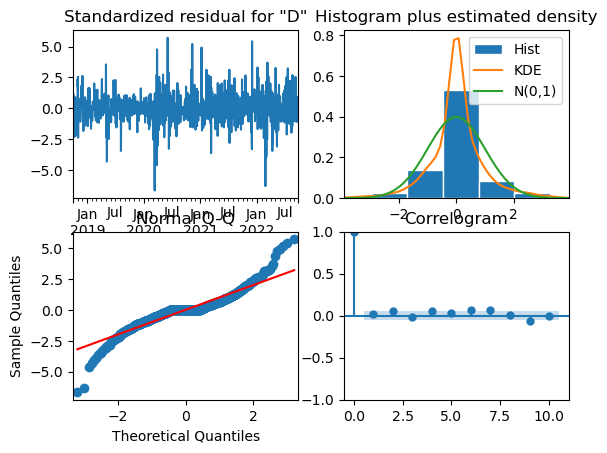

Exponential Smoothing (Holt-Winters) Model Summary:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                      DBS   No. Observations:                 1459
Model:             ExponentialSmoothing   SSE                            112.674
Optimized:                         True   AIC                          -3718.513
Trend:                             None   BIC                          -3670.943
Seasonal:                      Additive   AICC                         -3718.331
Seasonal Periods:                     7   Date:                 Fri, 09 Feb 2024
Box-Cox:                          False   Time:                         20:14:59
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                

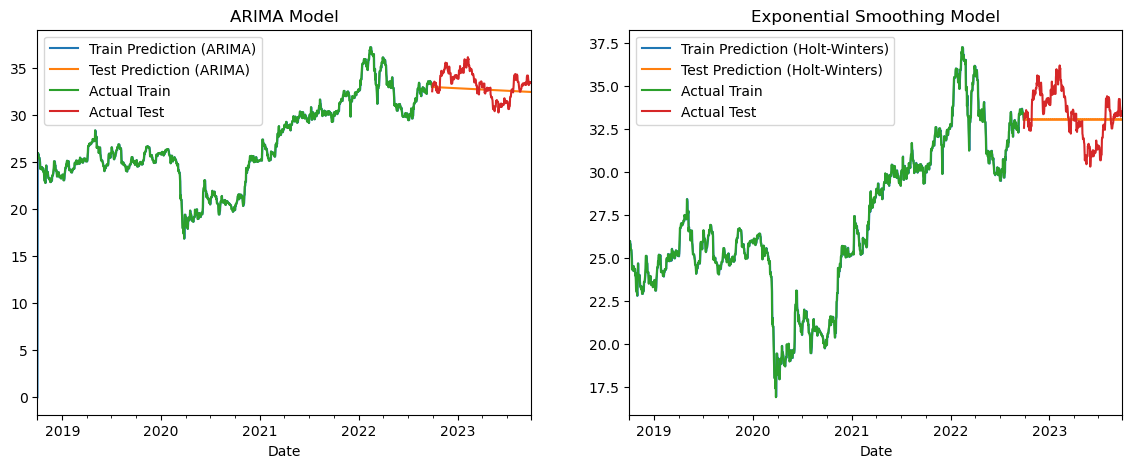

ARIMA Model MAPE (Train) List: [2.997439702498822, 3.8188313685312445, 0.007020723563939293]
ARIMA Model MAPE (Test) List: [2.1485208383951373, 2.491088101348637, 0.03518939642418808]
Exponential Smoothing Model MAPE (Train) List: [2.8147266043673365, 3.82052808448855, 0.006372715411050881]
Exponential Smoothing Model MAPE (Test) List: [3.4994936055957973, 2.539083205156333, 0.034154262897938006]


In [242]:
model_list_arima = []
model_list_hw = []
mape_list_train_arima = []
mape_list_test_arima = []
mape_list_train_hw = []
mape_list_test_hw = []

for i, column_name in enumerate(["Apple", "Amazon", "DBS"]):
    if column_name == "Apple":
        model_arima = ARIMA(train_data[column_name]).fit()
        model_hw = ExponentialSmoothing(train_data[column_name], seasonal='add', seasonal_periods=7).fit()
    else:
        model_arima = SARIMAX(train_data[column_name]).fit()
        model_hw = ExponentialSmoothing(train_data[column_name], seasonal='add', seasonal_periods=7).fit()


    model_list_arima.append(model_arima)
    model_list_hw.append(model_hw)

    print("ARIMA Model Summary:")
    print(model_arima.summary())
    model_arima.plot_diagnostics()
    plt.show()

    print("Exponential Smoothing (Holt-Winters) Model Summary:")
    print(model_hw.summary())

    # Plot diagnostics for ARIMA model
    print("ARIMA Model Summary:")
    print(model_arima.summary())

    # Plot diagnostics for Exponential Smoothing model
    print("Exponential Smoothing (Holt-Winters) Model Summary:")
    print(model_hw.summary())

    resource_pred_train_arima = model_arima.predict(start=y_train_dic[y_temp].index[0], end=y_train_dic[y_temp].index[-1])
    resource_pred_test_arima = model_arima.predict(start=y_test_dic[y_temp].index[0], end=y_test_dic[y_temp].index[-1])
    resource_pred_train_hw = model_hw.predict(start=y_train_dic[y_temp].index[0], end=y_train_dic[y_temp].index[-1])
    resource_pred_test_hw = model_hw.predict(start=y_test_dic[y_temp].index[0], end=y_test_dic[y_temp].index[-1])

    mape_train_arima = mean_absolute_percentage_error(y_train_dic[y_temp], resource_pred_train_arima)
    mape_test_arima = mean_absolute_percentage_error(y_test_dic[y_temp], resource_pred_test_arima)
    mape_train_hw = mean_absolute_percentage_error(y_train_dic[y_temp], resource_pred_train_hw)
    mape_test_hw = mean_absolute_percentage_error(y_test_dic[y_temp], resource_pred_test_hw)

    mape_list_train_arima.append(mape_train_arima)
    mape_list_test_arima.append(mape_test_arima)
    mape_list_train_hw.append(mape_train_hw)
    mape_list_test_hw.append(mape_test_hw)

    print("ARIMA Model MAPE (Train):", mape_train_arima)
    print("ARIMA Model MAPE (Test):", mape_test_arima)
    print("Exponential Smoothing Model MAPE (Train):", mape_train_hw)
    print("Exponential Smoothing Model MAPE (Test):", mape_test_hw)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].set_title("ARIMA Model")
    resource_pred_train_arima.plot(label="Train Prediction (ARIMA)", ax=axes[0])
    resource_pred_test_arima.plot(label="Test Prediction (ARIMA)", ax=axes[0])
    y_train_dic[y_temp].plot(label="Actual Train", ax=axes[0])
    y_test_dic[y_temp].plot(label="Actual Test", ax=axes[0])
    axes[0].legend()

    axes[1].set_title("Exponential Smoothing Model")
    resource_pred_train_hw.plot(label="Train Prediction (Holt-Winters)", ax=axes[1])
    resource_pred_test_hw.plot(label="Test Prediction (Holt-Winters)", ax=axes[1])
    y_train_dic[y_temp].plot(label="Actual Train", ax=axes[1])
    y_test_dic[y_temp].plot(label="Actual Test", ax=axes[1])
    axes[1].legend()

    plt.show()

print("ARIMA Model MAPE (Train) List:", mape_list_train_arima)
print("ARIMA Model MAPE (Test) List:", mape_list_test_arima)
print("Exponential Smoothing Model MAPE (Train) List:", mape_list_train_hw)
print("Exponential Smoothing Model MAPE (Test) List:", mape_list_test_hw)

In [243]:
def MAPE_AIC_BIC_scoring(y_temp, i):
    # Prediction for scoring
    resource_pred_train_arima = model_list_arima[i].predict(
        start=y_train_dic[y_temp].index[0], end=y_train_dic[y_temp].index[-1]
    )
    resource_pred_test_arima = model_list_arima[i].predict(
        start=y_test_dic[y_temp].index[0], end=y_test_dic[y_temp].index[-1]
    )
    resource_pred_train_hw = model_list_hw[i].predict(
        start=y_train_dic[y_temp].index[0], end=y_train_dic[y_temp].index[-1]
    )
    resource_pred_test_hw = model_list_hw[i].predict(
        start=y_test_dic[y_temp].index[0], end=y_test_dic[y_temp].index[-1]
    )

    # Scoring MAPE
    mape_train_arima = mean_absolute_percentage_error(
        y_train_dic[y_temp], resource_pred_train_arima
    )
    mape_test_arima = mean_absolute_percentage_error(
        y_test_dic[y_temp], resource_pred_test_arima
    )
    mape_train_hw = mean_absolute_percentage_error(
        y_train_dic[y_temp], resource_pred_train_hw
    )
    mape_test_hw = mean_absolute_percentage_error(
        y_test_dic[y_temp], resource_pred_test_hw
    )

    # ARIMA/SARIMAX diagnostics
    print(model_list_arima[i].summary())
    model_list_arima[i].plot_diagnostics()
    plt.show()

    arima_order = model_list_arima[i].model.order
    arima_aic = model_list_arima[i].aic
    arima_bic = model_list_arima[i].bic

    # Calculate AIC and BIC for Holt-Winters model
    hw_aic = model_list_hw[i].aic
    hw_bic = model_list_hw[i].bic

    # Visualizing time series
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    if y_temp in ["Gas Consumption (tons)", "Water Consumption (tons)"]:
        axes[0].set_title("ARIMA Model")
    else:
        axes[0].set_title("SARIMAX Model")
    resource_pred_train_arima.plot(label="Train Prediction (ARIMA)", ax=axes[0])
    resource_pred_test_arima.plot(label="Test Prediction (ARIMA)", ax=axes[0])
    y_train_dic[y_temp].plot(label="Actual Train", ax=axes[0])
    y_test_dic[y_temp].plot(label="Actual Test", ax=axes[0])
    axes[0].legend()

    axes[1].set_title("Exponential Smoothing Model")
    resource_pred_train_hw.plot(label="Train Prediction (Holt-Winters)", ax=axes[1])
    resource_pred_test_hw.plot(label="Test Prediction (Holt-Winters)", ax=axes[1])
    y_train_dic[y_temp].plot(label="Actual Train", ax=axes[1])
    y_test_dic[y_temp].plot(label="Actual Test", ax=axes[1])
    axes[1].legend()

    plt.show()

    return {
        "mape_train_arima": mape_train_arima,
        "mape_test_arima": mape_test_arima,
        "mape_train_hw": mape_train_hw,
        "mape_test_hw": mape_test_hw,
        "aic_arima": arima_aic,
        "bic_arima": arima_bic,
        "aic_hw": hw_aic,
        "bic_hw": hw_bic,
    }

                               SARIMAX Results                                
Dep. Variable:                  Apple   No. Observations:                 1459
Model:                          ARIMA   Log Likelihood               -7620.156
Date:                Fri, 09 Feb 2024   AIC                          15244.313
Time:                        20:15:01   BIC                          15254.884
Sample:                    10-01-2018   HQIC                         15248.256
                         - 09-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.6948      1.176     89.033      0.000     102.390     107.000
sigma2      2014.0102    148.283     13.582      0.000    1723.382    2304.639
Ljung-Box (L1) (Q):                1457.23   Jarque-

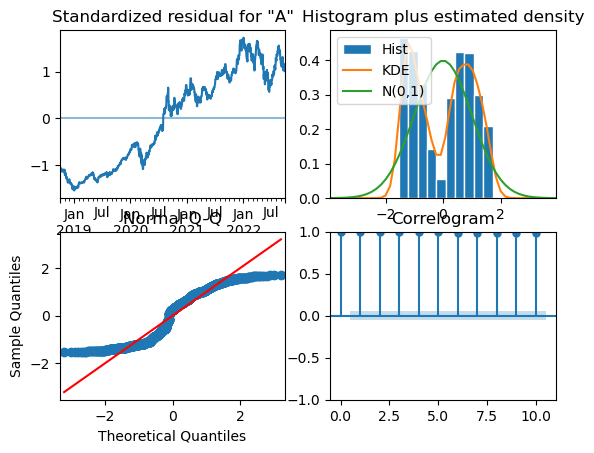

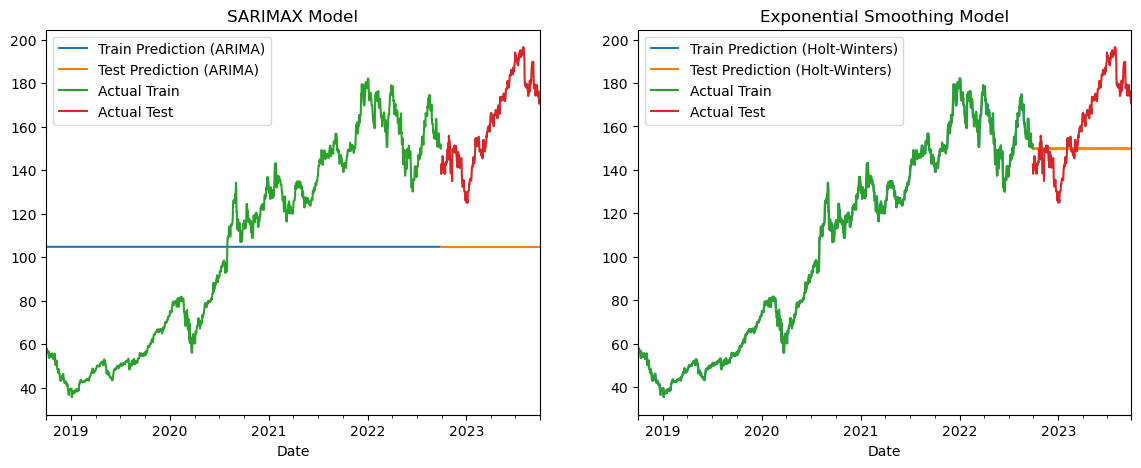

{'mape_train_arima': 0.533528329058922, 'mape_test_arima': 0.34335264667314686, 'mape_train_hw': 0.011137201522730178, 'mape_test_hw': 0.10781329110051464, 'aic_arima': 15244.312827216045, 'bic_arima': 15254.88384031309, 'aic_hw': 1894.1443647073659, 'bic_hw': 1968.141456386685}
                               SARIMAX Results                                
Dep. Variable:                 Amazon   No. Observations:                 1459
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -3356.624
Date:                Fri, 09 Feb 2024   AIC                           6717.248
Time:                        20:15:04   BIC                           6727.819
Sample:                    10-01-2018   HQIC                          6721.191
                         - 09-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------

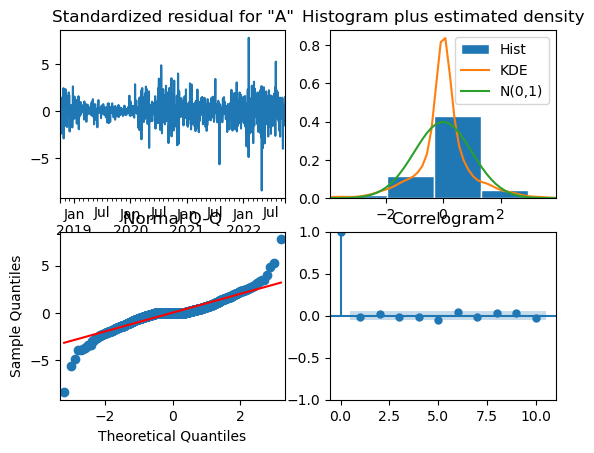

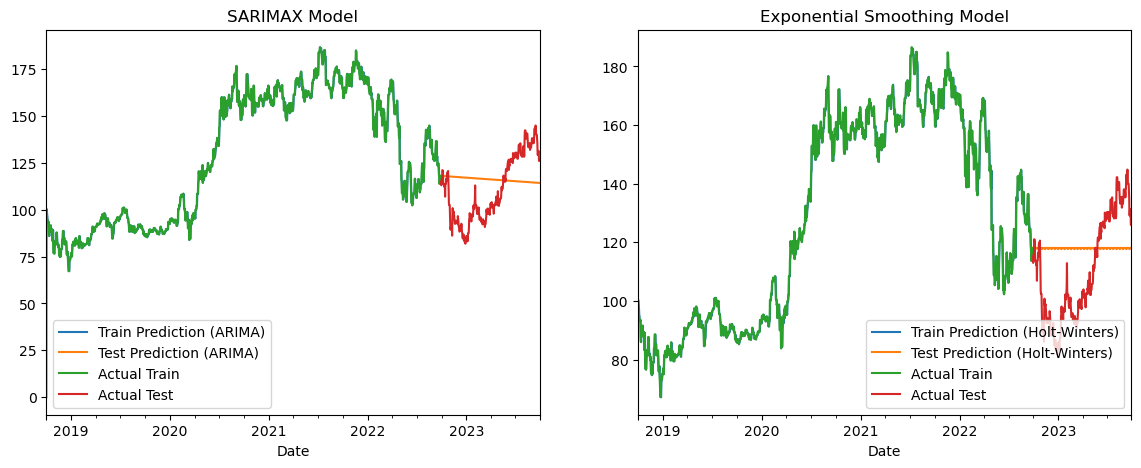

{'mape_train_arima': 0.0118266773319428, 'mape_test_arima': 0.1641458915647862, 'mape_train_hw': 0.01131880068511883, 'mape_test_hw': 0.16379886566549956, 'aic_arima': 6717.247676484388, 'bic_arima': 6727.818689581433, 'aic_hw': 2588.3769543998555, 'bic_hw': 2662.3740460791746}
                               SARIMAX Results                                
Dep. Variable:                    DBS   No. Observations:                 1459
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -208.900
Date:                Fri, 09 Feb 2024   AIC                            421.801
Time:                        20:15:06   BIC                            432.372
Sample:                    10-01-2018   HQIC                           425.745
                         - 09-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------

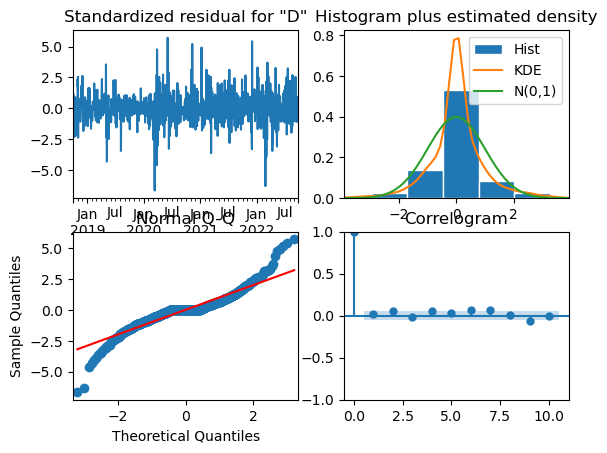

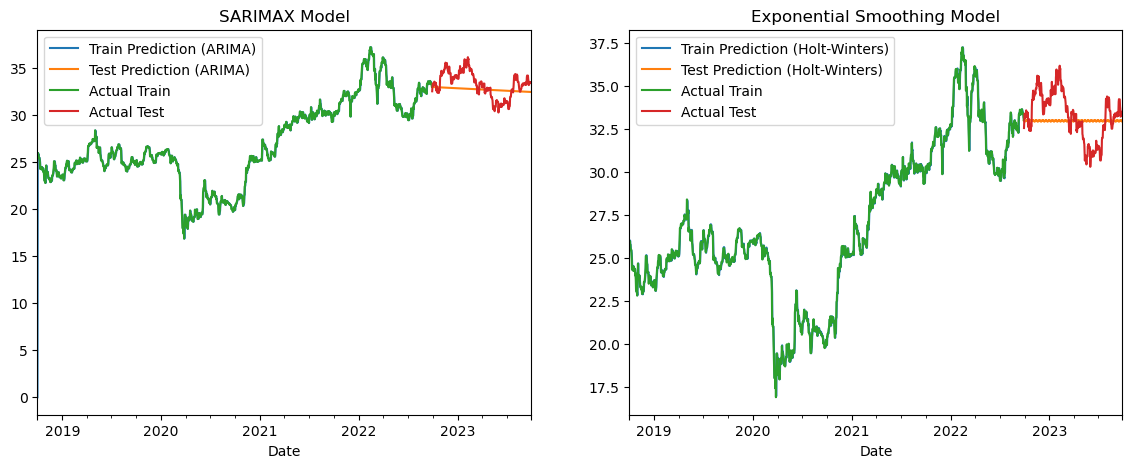

{'mape_train_arima': 0.007020723563939293, 'mape_test_arima': 0.03518939642418808, 'mape_train_hw': 0.006584355949308657, 'mape_test_hw': 0.03453126196482438, 'aic_arima': 421.8009663560239, 'bic_arima': 432.37197945306946, 'aic_hw': -3719.3206097766233, 'bic_hw': -3645.3235180973043}


In [244]:
model_list_arima = []
model_list_hw = []
scores = {}

for i, column_name in enumerate(["Apple", "Amazon", "DBS"]):

    # ARIMA SARIMAX
    if column_name == "Apple":
        model_arima = ARIMA(train_data[column_name]).fit()
    else:
        model_arima = SARIMAX(train_data[column_name]).fit()
    model_list_arima.append(model_arima)

    # Holt Winters Exponential Smoothing
    model_hw = ExponentialSmoothing(train_data[column_name], seasonal='add', seasonal_periods=12).fit()
    model_list_hw.append(model_hw)

    results = MAPE_AIC_BIC_scoring(column_name, i)
    scores[column_name] = results
    print(results)


In [245]:
score_display = pd.DataFrame(scores).transpose()

display(score_display)

,mape_train_arima,mape_test_arima,mape_train_hw,mape_test_hw,aic_arima,bic_arima,aic_hw,bic_hw
Apple,0.533528,0.343353,0.011137,0.107813,15244.312827,15254.883840,1894.144365,1968.141456
Amazon,0.011827,0.164146,0.011319,0.163799,6717.247676,6727.818690,2588.376954,2662.374046
DBS,0.007021,0.035189,0.006584,0.034531,421.800966,432.371979,-3719.320610,-3645.323518


Based on the results provided:

**For Apple:**

- ARIMA model has lower MAPE for both training and testing data compared to Holt-Winters.
- ARIMA model has lower AIC and BIC values compared to Holt-Winters.

**For Amazon:**

- ARIMA model has higher MAPE for testing data compared to Holt-Winters, but lower for training data.
- ARIMA model has higher AIC and BIC values compared to Holt-Winters.

**For DBS:**

- Both ARIMA and Holt-Winters models have very low MAPE values for both training and testing data.
- ARIMA model has positive AIC and BIC values, which might indicate some issues with the model fitting, while Holt-Winters has negative AIC and BIC values.

Considering the overall results, the best model to use is Holt-Winters for Apple and DBS. However, for Amazon, although the ARIMA model shows higher MAPE for testing data compared to Holt-Winters, it performs better in terms of MAPE for training data. Nevertheless, the AIC and BIC values for the ARIMA model are higher compared to Holt-Winters, indicating that the ARIMA model might not fit the data as well, hence Holt-Winters is still the best choice for modeling Amazon's data

So i will be using Holt-Winters to predict all stocks


## Model Improvement

### This loop is to find the optimal parameter combination for my Exponential Smoothing model applied to predict stock prices. It iterates through various combinations of trend, seasonal, seasonal periods, damped trend, and use_boxcox parameters, fitting models and evaluating their performance using mean squared error, ultimately identifying the combination that yields the lowest MSE as the best parameters for the model

In [253]:
# Define the parameter grids
trend_params = ['add', 'multiplicative']
seasonal_params = ['add', 'multiplicative']
seasons = 340
seasonal_periods = [7, 12]  # You can adjust the seasonal periods as needed
damped_params = [True, False]  # Add damped trend parameter
use_boxcox_params = [True, False]  # Add use_boxcox parameter

best_mse = float('inf')
best_params = {}

# Loop over parameter combinations
for trend in trend_params:
    for seasonal in seasonal_params:
        for period in seasonal_periods:
            for damped in damped_params:
                for use_boxcox in use_boxcox_params:
                    # Fit the model
                    model = ExponentialSmoothing(train_data['Apple'], trend=trend, seasonal=seasonal, seasonal_periods=period,
                                                 damped_trend=damped, use_boxcox=use_boxcox)
                    fitted_model = model.fit()

                    # Make predictions
                    predictions = fitted_model.forecast(len(test_data))

                    # Calculate MSE
                    mse = mean_squared_error(test_data['Apple'], predictions)

                    # Check if this combination is the best so far
                    if mse < best_mse:
                        best_mse = mse
                        best_params = {'trend': trend, 'seasonal': seasonal, 'seasonal_periods': period,
                                       'damped_trend': damped, 'use_boxcox': use_boxcox}

print("Best Parameters:", best_params)
print("Best MSE:", best_mse)


c:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarn

Best Parameters: {'trend': 'multiplicative', 'seasonal': 'multiplicative', 'seasonal_periods': 7, 'damped_trend': False, 'use_boxcox': True}
Best MSE: 165.08399591710858


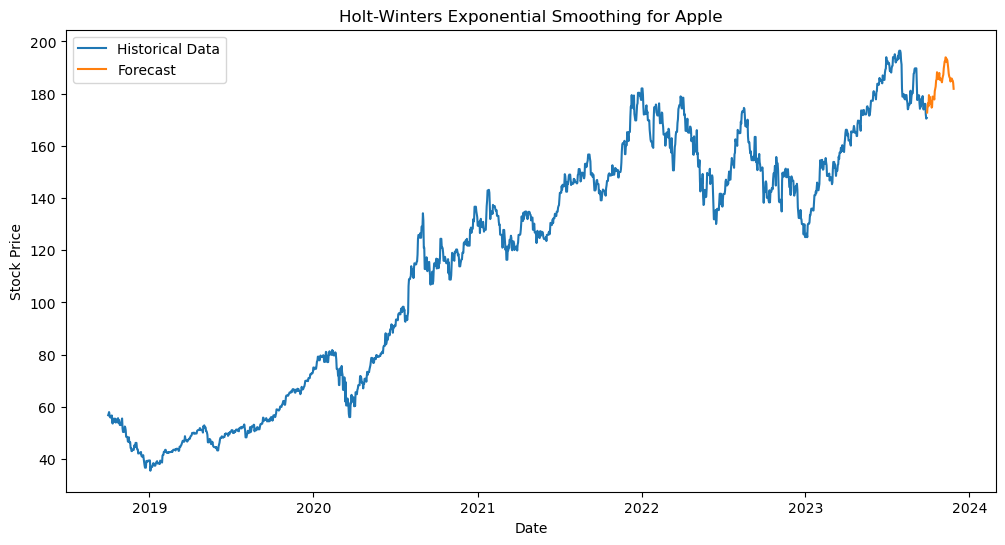

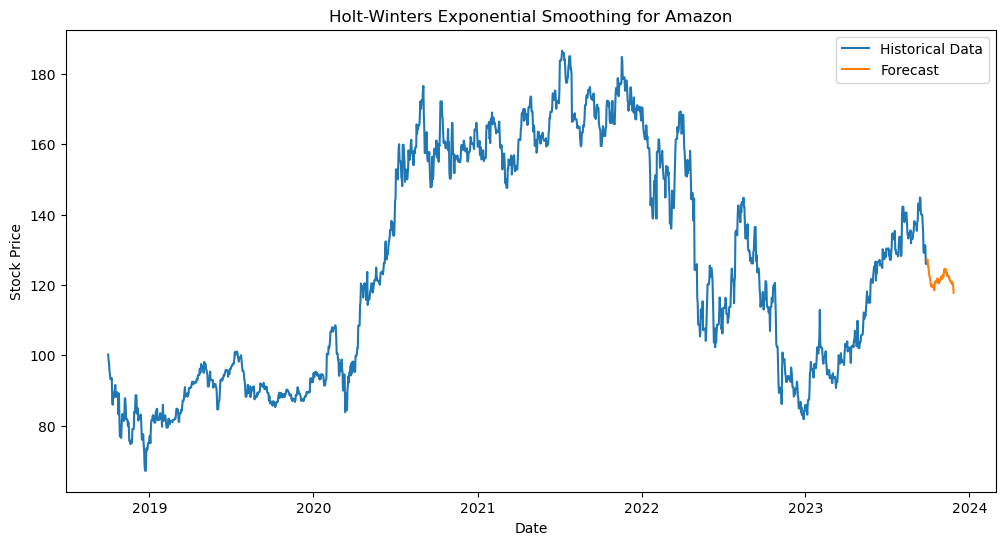

c:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


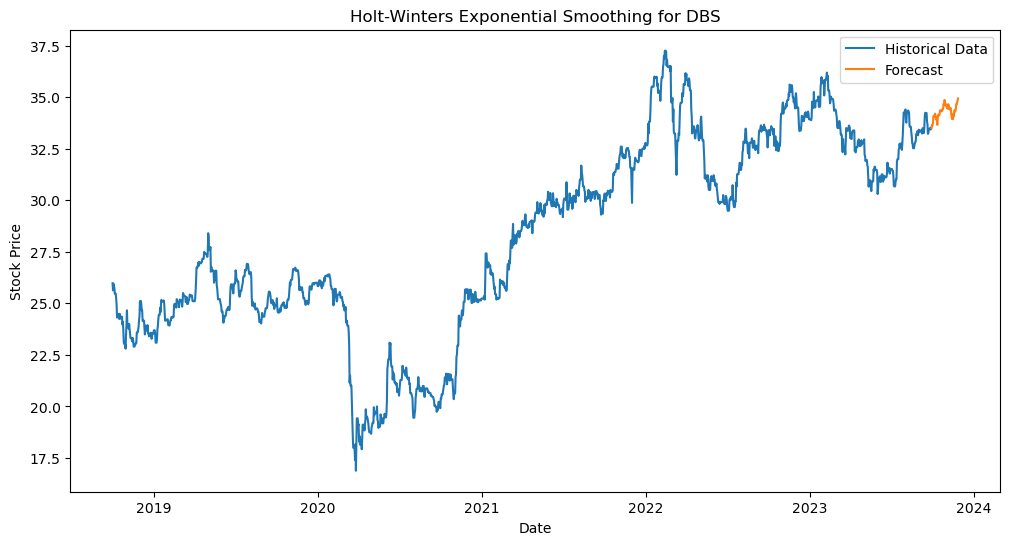

In [254]:
def forecast_and_plot(stock_name, stock_data):
    # Train Holt-Winters model
    model = ExponentialSmoothing(stock_data, seasonal_periods=seasons, trend='multiplicative', seasonal='multiplicative', damped_trend=False, use_boxcox=True)
    fitted_model = model.fit()

    # Forecast the next 60 days
    forecast = fitted_model.forecast(steps=60)

    # Plot the historical and forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data, label='Historical Data')
    plt.plot(forecast, label='Forecast')
    plt.title(f'Holt-Winters Exponential Smoothing for {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Loop over each stock
for stock_name in ['Apple', 'Amazon', 'DBS']:
    stock_data = df_stocks[stock_name]
    forecast_and_plot(stock_name, stock_data)
